### Download datasets

We can use the Hugging Face hub package to download data from the Global Streetscape repo. If the files are already present and up-to-date, they will not be downloaded again. Note that we are passing in the local data directory as specified in the environment/package config.

In [3]:
from streetscapes import conf
from huggingface_hub import hf_hub_download
filename = hf_hub_download(repo_id="NUS-UAL/global-streetscapes", filename="data/contextual.csv", repo_type="dataset", local_dir=conf.DATA_DIR)
print(conf.DATA_DIR)
print(filename)

/home/peter/urban-m4/streetscapes/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/peter/urban-m4/streetscapes/local/streetscapes-data
/home/peter/urban-m4/streetscapes/local/streetscapes-data/data/contextual.csv


There are quite a few files available. We found the following four files provide a good starting point.

In [13]:
for filename in [
    "contextual.csv",
    "metadata_common_attributes.csv",
    "segmentation.csv",
    "simplemaps.csv",
]:
    filename = hf_hub_download(
        repo_id="NUS-UAL/global-streetscapes", 
        filename=f"data/{filename}", 
        repo_type="dataset", 
        local_dir=conf.DATA_DIR
    )
    print(filename)

/home/peter/urban-m4/streetscapes/local/streetscapes-data/data/contextual.csv
/home/peter/urban-m4/streetscapes/local/streetscapes-data/data/metadata_common_attributes.csv
/home/peter/urban-m4/streetscapes/local/streetscapes-data/data/segmentation.csv
/home/peter/urban-m4/streetscapes/local/streetscapes-data/data/simplemaps.csv


### Exploring the data

One option to explore the data is using pandas. However, pandas might not be the most suitable in this case. It has trouble identifying data types and as a result, parses many columns into objects. It also has a tendency to load lots of data into memory. Notice the memory consumption below: the contextual dataset with (only) 10 columns already uses over 800MB. The other datasets are much bigger. 

In [8]:
import pandas as pd

df = pd.read_csv(conf.DATA_DIR / "data" / "contextual.csv")
print(df.info())

/tmp/ipykernel_3420239/1074163805.py:3: DtypeWarning: Columns (5,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(conf.DATA_DIR / "data" / "contextual.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10004551 entries, 0 to 10004550
Data columns (total 11 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   uuid                object
 1   source              object
 2   orig_id             int64 
 3   glare               object
 4   lighting_condition  object
 5   pano_status         object
 6   platform            object
 7   quality             object
 8   reflection          object
 9   view_direction      object
 10  weather             object
dtypes: int64(1), object(10)
memory usage: 839.6+ MB
None


DuckDB might be more suitable to explore this dataset. This package can query the data without loading it into memory. For example:

In [26]:
import duckdb

print(duckdb.sql(f"SELECT * FROM '{conf.DATA_DIR / 'data' / 'simplemaps.csv'}'"))
print(duckdb.sql(f"SELECT * FROM '{conf.DATA_DIR / 'data' / 'metadata_common_attributes.csv'}'"))

┌──────────────────────────────────────┬───────────┬──────────────────┬──────────┬────────────┬────────────┬──────────┬──────────┬─────────┬─────────┬─────────┬────────────┬─────────┬────────────┬───────────┐
│                 uuid                 │  source   │     orig_id      │   city   │ city_ascii │  city_id   │ city_lat │ city_lon │ country │  iso2   │  iso3   │ admin_name │ capital │ population │ continent │
│               varchar                │  varchar  │      int64       │ varchar  │  varchar   │   int64    │  double  │  double  │ varchar │ varchar │ varchar │  varchar   │ varchar │   double   │  varchar  │
├──────────────────────────────────────┼───────────┼──────────────────┼──────────┼────────────┼────────────┼──────────┼──────────┼─────────┼─────────┼─────────┼────────────┼─────────┼────────────┼───────────┤
│ d3cca4a7-7994-47ff-9749-7df8ca7228e3 │ Mapillary │  412070930384924 │ Urasoe   │ Urasoe     │ 1392003314 │  26.2458 │ 127.7219 │ Japan   │ JP      │ JPN     │ Oki

DuckDB can also combine the dataframes very efficiently, so we can easily get a subset of the data using conditions on multiple CSVs:

In [14]:
duckdb.sql(f"""         
            SELECT *
            FROM read_csv('{conf.DATA_DIR}/data/contextual.csv') AS contextual
            JOIN read_csv('{conf.DATA_DIR}/data/simplemaps.csv') AS simplemaps
            USING (UUID, source, orig_id)
            WHERE simplemaps.city = 'Amsterdam' AND contextual.view_direction = 'side'
           """)

┌──────────────────────────────────────┬───────────┬──────────────────┬─────────┬────────────────────┬─────────────┬─────────────────┬───────────────┬────────────┬────────────────┬─────────┬───────────┬────────────┬────────────┬──────────┬──────────┬─────────────┬─────────┬─────────┬───────────────┬─────────┬────────────┬───────────┐
│                 uuid                 │  source   │     orig_id      │  glare  │ lighting_condition │ pano_status │    platform     │    quality    │ reflection │ view_direction │ weather │   city    │ city_ascii │  city_id   │ city_lat │ city_lon │   country   │  iso2   │  iso3   │  admin_name   │ capital │ population │ continent │
│               varchar                │  varchar  │      int64       │ boolean │      varchar       │   boolean   │     varchar     │    varchar    │  boolean   │    varchar     │ varchar │  varchar  │  varchar   │   int64    │  double  │  double  │   varchar   │ varchar │ varchar │    varchar    │ varchar │   double   │  var

Now, we can add the third csv file to get the exact latitude and longitude of each image. Let's fetch the results into a pandas dataframe.

In [ ]:
df = duckdb.sql(f"""         
            SELECT metadata.lat, metadata.lon, contextual.quality
            FROM read_csv('{conf.DATA_DIR}/data/contextual.csv') AS contextual
            JOIN read_csv('{conf.DATA_DIR}/data/simplemaps.csv') AS simplemaps
            USING (UUID, source, orig_id)
            JOIN read_csv('{conf.DATA_DIR}/data/metadata_common_attributes.csv') AS metadata
            USING (UUID, source, orig_id)
            WHERE simplemaps.city = 'Amsterdam' AND contextual.view_direction = 'side'
           """).df()
df.head()

,lat,lon,quality
0,52.368777,4.886599,good
1,52.366920,4.879915,good
2,52.366746,4.880038,good
3,52.368967,4.878343,good
4,52.367346,4.879598,good


Finally, we can convert this to a geopandas dataframe so we can easily plot it.

<Axes: >

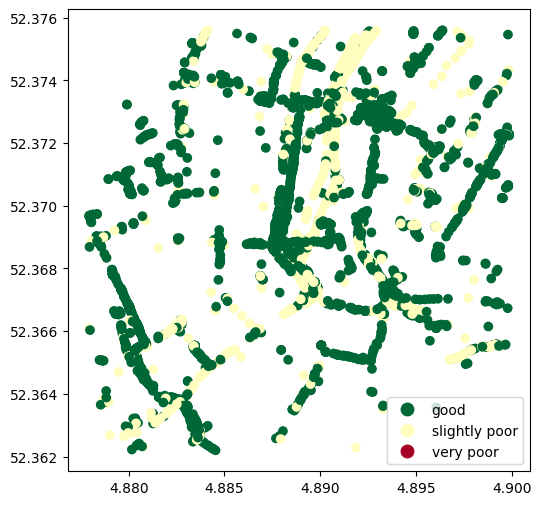

In [37]:
import geopandas as gpd

gdf = gpd.GeoDataFrame(df.quality, geometry=gpd.points_from_xy(df.lon, df.lat))
gdf.set_crs("EPSG:4326", allow_override=True, inplace=True)
gdf.plot(column='quality', cmap='RdYlGn_r', legend=True, figsize=(10, 6))

TODO: 
- Add example on how to easily add all columns?
- Check against `load_city_subset` function, maybe use this code instead?


In [2]:
load_city_subset('Amsterdam')

Streetscapes | 2025-01-14@16:06:53 | Creating subset for 'Amsterdam'...


FileNotFoundError: [Errno 2] No such file or directory: '/home/peter/urban-m4/streetscapes/src/local/output/streetscapes-data.parquet'